# Importing Libraries

In [1]:
import torch 
import torch.nn as nn 
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader 
from torchsummary import summary 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np 

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Loading and Exploration

In [4]:
df = pd.read_csv("riceClassification.csv")
df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [5]:
df.shape

(18185, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18185 entries, 0 to 18184
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               18185 non-null  int64  
 1   Area             18185 non-null  int64  
 2   MajorAxisLength  18185 non-null  float64
 3   MinorAxisLength  18185 non-null  float64
 4   Eccentricity     18185 non-null  float64
 5   ConvexArea       18185 non-null  int64  
 6   EquivDiameter    18185 non-null  float64
 7   Extent           18185 non-null  float64
 8   Perimeter        18185 non-null  float64
 9   Roundness        18185 non-null  float64
 10  AspectRation     18185 non-null  float64
 11  Class            18185 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 1.7 MB


In [7]:
df.Class.value_counts() # To check Class imbalance

Class
1    9985
0    8200
Name: count, dtype: int64

# Data Preprocessing

In [8]:
X = df.drop(columns="Class", axis=1)
y = df["Class"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(12729, 11)
(12729,)
(2728, 11)
(2728,)
(2728, 11)
(2728,)


In [10]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) #no fit_transform
X_val_scaled = scaler.transform(X_val)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_val = pd.DataFrame(X_val_scaled, columns=X_val.columns)

After this we need to change the df to tensors

`Method #1` -- quick and simple  

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)  
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

`Method #2` -- Standard way - `TensorDataset + DataLoader`

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)   
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

`Method #3` -- By creating our own Dataset Class    

from torch.utils.data import Dataset    
class MyDataset(Dataset):  # Dataset is already a class, we are subclassing and modifying some of the functions
    def __init__(self, X, y):  
        self.X = torch.tensor(X.values, dtype=torch.float32)  
        self.y = torch.tensor(y.values, dtype=torch.float32)    
    def __len__(self):  
        return len(self.X)    
    def __getitem__(self, idx):  
        return self.X[idx], self.y[idx]  
train_dataset = MyDataset(X_train, y_train)

In [11]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32).to(device)
        self.y = torch.tensor(y.values, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [12]:
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)
val_dataset = MyDataset(X_val, y_val)

In [13]:
BATCH_SIZE = 32
EPOCHS = 10
HIDDEN_NEURONS = 10
LR = 1e-3

In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)

In [15]:
for x,y in train_loader:  # sample of how data in X and y are stored in data loader
    print(x)
    print("----------")
    print(y)
    break

tensor([[-0.0242, -0.4824,  0.8489, -0.8961,  1.1260, -0.4815, -0.4407, -1.5208,
          0.1681, -1.2264,  1.3679],
        [-0.6802, -0.5260,  0.2751, -0.7393,  0.8484, -0.4948, -0.4866, -1.2336,
         -0.1102, -0.8802,  0.8338],
        [ 0.6624,  1.6844,  0.8329,  1.5372, -0.9808,  1.6364,  1.6041,  1.1174,
          1.2422,  1.2484, -1.0264],
        [-0.0826, -0.6616,  0.5032, -0.9896,  1.0981, -0.6612, -0.6309, -0.2542,
         -0.1586, -1.1089,  1.3083],
        [ 0.3940,  1.3137,  0.2934,  1.4294, -1.2099,  1.2950,  1.2818,  0.8160,
          0.8070,  1.3497, -1.1619],
        [-1.6559, -2.2390, -3.5283, -1.4813, -0.2054, -2.2500, -2.5252, -0.2923,
         -3.4020,  0.6083, -0.4541],
        [-1.4389, -0.3823, -0.0778, -0.3719,  0.4203, -0.3584, -0.3361,  0.9155,
         -0.1988, -0.4038,  0.2052],
        [-1.4959, -0.9287, -0.9718, -0.7144,  0.3550, -0.9648, -0.9222, -0.9805,
         -1.1665,  0.0178,  0.1245],
        [ 0.7190,  1.4663,  0.6546,  1.3970, -0.9399,  1

In [16]:
class MyModel(nn.Module):
    def __init__(self):

        super(MyModel, self).__init__()   # In dataset class we created constructor from scratch
                                          # But here we are using same contructor of nn.module using super

        self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS) # X.shape[1] return the input features 
        self.linear = nn.Linear(HIDDEN_NEURONS, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x

model = MyModel().to(device)

#### Why constructor__init()?

By defining them in __init__(), PyTorch can:

- Register them as learnable parameters

- Track them for autograd

- Save and load them correctly using .state_dict()

In [17]:
summary(model, (X.shape[1],))  # for pytorch you need to pass input shape too unlike tensorflow

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             120
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 131
Trainable params: 131
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [18]:
criterion = nn.BCELoss() # binary cross-entropy loss
optimizer = Adam(model.parameters(), lr= LR)

# Training and Validation

In [19]:
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0

    for inputs, labels in train_loader:
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()  
    val_loss = 0.0

    with torch.no_grad():  
        for inputs, labels in val_loader:
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


Epoch 1/10, Train Loss: 0.1411, Val Loss: 0.0271
Epoch 2/10, Train Loss: 0.0161, Val Loss: 0.0096
Epoch 3/10, Train Loss: 0.0070, Val Loss: 0.0051
Epoch 4/10, Train Loss: 0.0039, Val Loss: 0.0030
Epoch 5/10, Train Loss: 0.0025, Val Loss: 0.0019
Epoch 6/10, Train Loss: 0.0017, Val Loss: 0.0013
Epoch 7/10, Train Loss: 0.0013, Val Loss: 0.0009
Epoch 8/10, Train Loss: 0.0010, Val Loss: 0.0007
Epoch 9/10, Train Loss: 0.0009, Val Loss: 0.0006
Epoch 10/10, Train Loss: 0.0007, Val Loss: 0.0004


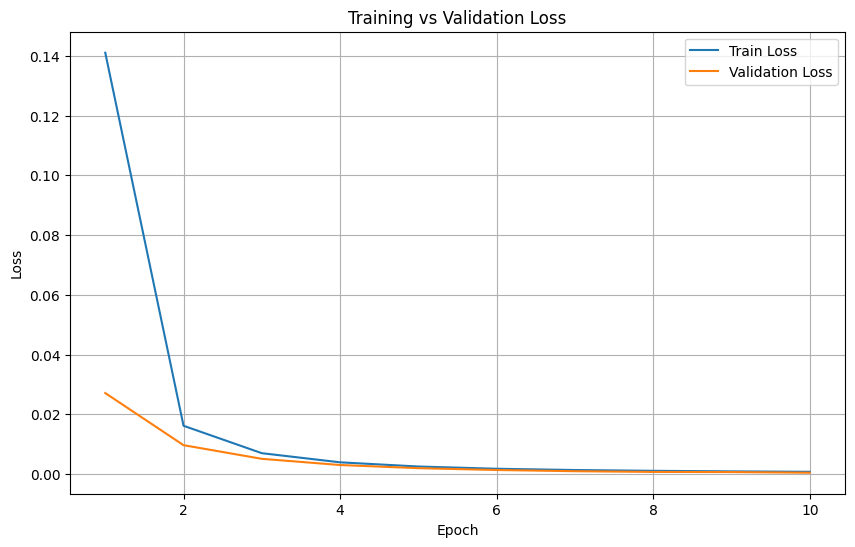

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), train_losses, label='Train Loss')
plt.plot(range(1, EPOCHS+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Testing and Evaluation

In [25]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0

    for inputs, labels in test_loader:
        outputs = model(inputs).squeeze()
        predicted = (outputs >= 0.5).float()  
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 1.0000
